In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
import shap
import socket
import matplotlib.pyplot as plt
from tqdm import tqdm

d:\Prog\iomt-anomalyze\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from sklearn.metrics import precision_score, recall_score, f1_score

In [3]:
import seaborn as sns
import os
import gc
import math
import time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

from imblearn.under_sampling import ClusterCentroids
from imblearn.combine import SMOTEENN

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np

In [5]:
import tensorflow as tf
from tensorflow.keras import layers, models

In [6]:
from sdv.single_table import CTGANSynthesizer
from sklearn.utils import resample

In [7]:
df = pd.read_csv("../../data/raw/CIC_IoMT_2024_WiFi_MQTT_train.csv")

In [8]:
label_mapping = {
    'Benign': ['Benign_train'],
    
    'Spoofing': ['ARP_Spoofing_train'],

    'Reconnaissance': [
        'Recon-OS_Scan_train',
        'Recon-Ping_Sweep_train',
        'Recon-VulScan_train',
        'Recon-Port_Scan_train'
    ],
    
    'MQTT': [
        'MQTT-Malformed_Data_train',
        'MQTT-DoS-Connect_Flood_train',
        'MQTT-DDoS-Publish_Flood_train',
        'MQTT-DoS-Publish_Flood_train',
        'MQTT-DDoS-Connect_Flood_train'
    ],

    'DoS': [
        'TCP_IP-DoS-TCP1_train', 'TCP_IP-DoS-TCP2_train', 'TCP_IP-DoS-TCP3_train', 'TCP_IP-DoS-TCP4_train',
        'TCP_IP-DoS-UDP1_train', 'TCP_IP-DoS-UDP2_train', 'TCP_IP-DoS-UDP3_train', 'TCP_IP-DoS-UDP4_train',
        'TCP_IP-DoS-ICMP1_train', 'TCP_IP-DoS-ICMP2_train', 'TCP_IP-DoS-ICMP3_train', 'TCP_IP-DoS-ICMP4_train',
        'TCP_IP-DoS-SYN1_train', 'TCP_IP-DoS-SYN2_train', 'TCP_IP-DoS-SYN3_train', 'TCP_IP-DoS-SYN4_train'
    ],

    'DDoS': [
        'TCP_IP-DDoS-TCP1_train', 'TCP_IP-DDoS-TCP2_train', 'TCP_IP-DDoS-TCP3_train', 'TCP_IP-DDoS-TCP4_train',
        'TCP_IP-DDoS-UDP1_train', 'TCP_IP-DDoS-UDP2_train', 'TCP_IP-DDoS-UDP3_train', 'TCP_IP-DDoS-UDP4_train',
        'TCP_IP-DDoS-UDP5_train', 'TCP_IP-DDoS-UDP6_train', 'TCP_IP-DDoS-UDP7_train', 'TCP_IP-DDoS-UDP8_train',
        'TCP_IP-DDoS-ICMP1_train', 'TCP_IP-DDoS-ICMP2_train', 'TCP_IP-DDoS-ICMP3_train', 'TCP_IP-DDoS-ICMP4_train',
        'TCP_IP-DDoS-ICMP5_train', 'TCP_IP-DDoS-ICMP6_train', 'TCP_IP-DDoS-ICMP7_train', 'TCP_IP-DDoS-ICMP8_train',
        'TCP_IP-DDoS-SYN1_train', 'TCP_IP-DDoS-SYN2_train', 'TCP_IP-DDoS-SYN3_train', 'TCP_IP-DDoS-SYN4_train'
    ]
}

In [9]:
def map_category(label):
    for parent, sub_labels in label_mapping.items():
        if label in sub_labels:
            return parent
    return 'Unknown'
df['SuperClass'] = df['label'].apply(map_category)

In [10]:
grouped = df.groupby(['SuperClass', 'label']).size().reset_index(name='Records')
total = len(df)
grouped['Percentage'] = (grouped['Records'] / total) * 100

summary = grouped.groupby('SuperClass')['Records'].sum().reset_index()
summary['Percentage'] = (summary['Records'] / total) * 100

print("Hierarchical Breakdown:")
display(grouped.sort_values(['SuperClass', 'Records'], ascending=[True, False]).head(20))

print("Category Summary:")
display(summary)

Hierarchical Breakdown:


,SuperClass,label,Records,Percentage
0,Benign,Benign_train,192732,2.691475
18,DDoS,TCP_IP-DDoS-UDP2_train,207295,2.894846
19,DDoS,TCP_IP-DDoS-UDP3_train,206604,2.885196
20,DDoS,TCP_IP-DDoS-UDP4_train,206343,2.881551
17,DDoS,TCP_IP-DDoS-UDP1_train,206170,2.879135
21,DDoS,TCP_IP-DDoS-UDP5_train,205507,2.869876
24,DDoS,TCP_IP-DDoS-UDP8_train,204105,2.850298
15,DDoS,TCP_IP-DDoS-TCP3_train,204075,2.849879
10,DDoS,TCP_IP-DDoS-SYN2_train,203669,2.844209
13,DDoS,TCP_IP-DDoS-TCP1_train,202311,2.825245


Category Summary:


,SuperClass,Records,Percentage
0,Benign,192732,2.691475
1,DDoS,4779859,66.750060
2,DoS,1805529,25.213959
3,MQTT,262938,3.671892
4,Reconnaissance,103726,1.448519
5,Spoofing,16047,0.224094


In [11]:
ID_COLS = ['label', 'SuperClass']

In [12]:
DROP_COLS = ['Boot_Time_with_date', 'RTime', 'SrcAddr', 'DstAddr', 'SrcMac', 'DstMac', 'IMEI']

In [13]:
RATE_COLS = ['Rate', 'Srate', 'Drate'] 

In [14]:
cols_to_drop = [c for c in DROP_COLS if c in df.columns]
if cols_to_drop:
    print("Dropping ID/time columns:", cols_to_drop)
    df = df.drop(columns=cols_to_drop)

In [15]:
df.head()

,Header_Length,Protocol Type,Duration,Rate,Srate,Drate,fin_flag_number,syn_flag_number,rst_flag_number,psh_flag_number,...,Tot size,IAT,Number,Magnitue,Radius,Covariance,Variance,Weight,label,SuperClass
0,683.50,17.00,64.0,553148.440,553148.440,0,0.0,0.0,0.0,0.00,...,50.00,101635944.0,9.5,10.00,0.000,0.000000,0.00,141.5,TCP_IP-DDoS-UDP2_train,DDoS
1,1745.92,16.12,64.0,29919.545,29919.545,0,0.0,0.0,0.0,0.04,...,52.28,84696616.0,9.5,10.05,2.152,11.785338,0.23,141.5,TCP_IP-DDoS-UDP2_train,DDoS
2,2830.36,15.79,64.0,27075.605,27075.605,0,0.0,0.0,0.0,0.06,...,53.25,84696616.0,9.5,10.35,10.555,113.675460,0.53,141.5,TCP_IP-DDoS-UDP2_train,DDoS
3,4087.50,16.89,64.0,19660.156,19660.156,0,0.0,0.0,0.0,0.00,...,50.16,84696616.0,9.5,10.03,1.236,4.490081,0.18,141.5,TCP_IP-DDoS-UDP2_train,DDoS
4,3916.00,17.00,64.0,270322.780,270322.780,0,0.0,0.0,0.0,0.00,...,50.00,84696616.0,9.5,10.00,0.000,0.000000,0.00,141.5,TCP_IP-DDoS-UDP2_train,DDoS


In [16]:
df['SuperClass'].value_counts()

SuperClass
DDoS              4779859
DoS               1805529
MQTT               262938
Benign             192732
Reconnaissance     103726
Spoofing            16047
Name: count, dtype: int64

In [17]:
num_cols = df.select_dtypes(include=['float64', 'int64']).columns.tolist()

In [18]:
num_cols

['Header_Length',
 'Protocol Type',
 'Duration',
 'Rate',
 'Srate',
 'Drate',
 'fin_flag_number',
 'syn_flag_number',
 'rst_flag_number',
 'psh_flag_number',
 'ack_flag_number',
 'ece_flag_number',
 'cwr_flag_number',
 'ack_count',
 'syn_count',
 'fin_count',
 'rst_count',
 'HTTP',
 'HTTPS',
 'DNS',
 'Telnet',
 'SMTP',
 'SSH',
 'IRC',
 'TCP',
 'UDP',
 'DHCP',
 'ARP',
 'ICMP',
 'IGMP',
 'IPv',
 'LLC',
 'Tot sum',
 'Min',
 'Max',
 'AVG',
 'Std',
 'Tot size',
 'IAT',
 'Number',
 'Magnitue',
 'Radius',
 'Covariance',
 'Variance',
 'Weight']

In [19]:
LABEL_COL = 'SuperClass'
SAMPLES_GEN=30000

In [20]:
spoof_df = df[df[LABEL_COL] == 'Spoofing'].copy()

In [21]:
spoof_df.shape

(16047, 47)

In [22]:
gen = SAMPLES_GEN - len(spoof_df)

In [23]:
gen

13953

In [24]:
from sdv.metadata import Metadata

In [25]:
metadata = Metadata.detect_from_dataframe(
    data=spoof_df,
    table_name='spoofing_table')

In [26]:
ctgan = CTGANSynthesizer(metadata, epochs=50, verbose=True)

d:\Prog\iomt-anomalyze\venv\Lib\site-packages\sdv\single_table\base.py:134: UserWarning: We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.
  warnings.warn(


In [27]:
cat_cols = [c for c in df.columns if c not in num_cols + [LABEL_COL, 'label']]

In [28]:
ctgan.fit(spoof_df)

d:\Prog\iomt-anomalyze\venv\Lib\site-packages\ctgan\synthesizers\_utils.py:16: FutureWarning: `cuda` parameter is deprecated and will be removed in a future release. Please use `enable_gpu` instead.
  warnings.warn(
Gen. (0.52) | Discrim. (0.48): 100%|██████████| 50/50 [01:37<00:00,  1.95s/it]  


In [29]:
fig = ctgan.get_loss_values_plot()
fig

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'hovertemplate': 'variable=Generator Loss<br>Epoch=%{x}<br>value=%{y}<extra></extra>',
              'legendgroup': 'Generator Loss',
              'line': {'color': '#000036', 'dash': 'solid'},
              'marker': {'symbol': 'circle'},
              'mode': 'lines',
              'name': 'Generator Loss',
              'orientation': 'v',
              'showlegend': True,
              'type': 'scatter',
              'x': {'bdata': 'AAECAwQFBgcICQoLDA0ODxAREhMUFRYXGBkaGxwdHh8gISIjJCUmJygpKissLS4vMDE=', 'dtype': 'i1'},
              'xaxis': 'x',
              'y': {'bdata': ('AAAAQKwi4L8AAACAggICwAAAAODN+w' ... 'CLzcK/AAAAAIIo8r8AAABgh6LgPw=='),
                    'dtype': 'f8'},
              'yaxis': 'y'},
             {'hovertemplate': 'variable=Discriminator Loss<br>Epoch=%{x}<br>value=%{y}<extra></extra>',
              'legendgroup': 'Discriminator Loss',
              'line': {'color': '#01E0C9', 'dash': 'solid'},
              'marker': {'symbol': 'circle'},
              'mode': 'lines',
              'name': 'Discriminator Loss',
              'orientation': 'v',
              'showlegend': True,
              'type': 'scatter',
              'x': {'bdata': 'AAECAwQFBgcICQoLDA0ODxAREhMUFRYXGBkaGxwdHh8gISIjJCUmJygpKissLS4vMDE=', 'dtype': 'i1'},
              'xaxis': 'x',
              'y': {'bdata': ('AAAAoOlN4r8AAAAAfEfRPwAAAACtFt' ... 'AaQfO/AAAAAPOUx78AAACglKrePw=='),
                    'dtype': 'f8'},
              'yaxis': 'y'}],
    'layout': {'font': {'size': 18},
               'legend': {'orientation': 'v', 'title': {'text': ''}, 'tracegroupgap': 0},
               'margin': {'t': 60},
               'plot_bgcolor': '#F5F5F8',
               'template': '...',
               'title': {'text': 'CTGAN loss function'},
               'xaxis': {'anchor': 'y', 'domain': [0.0, 1.0], 'title': {'text': 'Epoch'}},
               'yaxis': {'anchor': 'x', 'domain': [0.0, 1.0], 'title': {'text': 'Loss'}}}
})

In [30]:
synth_data = ctgan.sample(gen)

In [31]:
synth_data

,Header_Length,Protocol Type,Duration,Rate,Srate,Drate,fin_flag_number,syn_flag_number,rst_flag_number,psh_flag_number,...,Tot size,IAT,Number,Magnitue,Radius,Covariance,Variance,Weight,label,SuperClass
0,0.00,6.065,63.0,288.393953,268.416687,0,0.0,0.0,0.0,0.23,...,142.3,1.694028e+08,5.5,24.953,480.1517,4337.460253,0.9970,242.865,ARP_Spoofing_train,Spoofing
1,0.00,5.930,76.1,307.058848,0.011909,0,0.0,0.0,0.0,0.42,...,56.2,1.673049e+08,5.6,55.030,0.0000,0.000000,1.0000,244.600,ARP_Spoofing_train,Spoofing
2,4149018.69,16.999,64.4,367.680249,209.211404,0,0.0,0.0,0.0,0.00,...,111.9,1.694028e+08,13.5,30.742,992.0000,0.000000,0.9799,40.574,ARP_Spoofing_train,Spoofing
3,3014305.09,6.140,62.7,275.817695,0.011909,0,0.0,0.0,0.0,0.00,...,337.6,0.000000e+00,13.6,16.438,572.1612,62973.414511,0.9916,37.905,ARP_Spoofing_train,Spoofing
4,71090.31,17.000,80.6,275.562466,0.011909,0,0.0,0.0,0.0,0.01,...,551.2,1.694028e+08,13.6,14.998,27.7963,349504.455379,1.0000,242.075,ARP_Spoofing_train,Spoofing
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13948,916785.94,16.955,64.3,241.855781,156.701364,0,0.0,0.0,0.0,0.01,...,689.1,0.000000e+00,13.5,34.722,706.2774,44246.450143,0.9897,244.600,ARP_Spoofing_train,Spoofing
13949,7384703.84,16.878,0.0,66.668892,116.347716,0,0.0,0.0,0.0,0.93,...,51.0,0.000000e+00,5.6,13.082,258.8911,0.000000,0.0000,35.841,ARP_Spoofing_train,Spoofing
13950,11451.53,16.738,105.0,0.011909,0.011909,0,0.0,0.0,0.0,0.00,...,114.7,1.676984e+08,5.7,13.691,1.4898,0.000000,1.0000,242.614,ARP_Spoofing_train,Spoofing
13951,6593330.61,6.181,65.2,11.239260,239.539507,0,0.0,0.0,0.0,0.48,...,1508.8,0.000000e+00,5.5,25.103,0.0000,0.000000,0.8906,241.583,ARP_Spoofing_train,Spoofing


In [32]:
synth_data[LABEL_COL] = 'Spoofing'

In [33]:
spoof_balanced = pd.concat([spoof_df, synth_data], ignore_index=True)

In [34]:
spoof_balanced

,Header_Length,Protocol Type,Duration,Rate,Srate,Drate,fin_flag_number,syn_flag_number,rst_flag_number,psh_flag_number,...,Tot size,IAT,Number,Magnitue,Radius,Covariance,Variance,Weight,label,SuperClass
0,866.60,10.400,64.0,45722.390000,45722.390000,0,0.0,0.0,0.0,0.30,...,431.8,1.694026e+08,5.5,16.970,213.1000,66236.080000,0.9000,38.500,ARP_Spoofing_train,Spoofing
1,3934.30,12.600,131.2,35708.800000,35708.800000,0,0.0,0.0,0.0,0.30,...,406.2,1.694026e+08,13.5,30.890,709.0000,251721.120000,1.0000,244.600,ARP_Spoofing_train,Spoofing
2,5592.80,12.600,97.6,66.403500,66.403500,0,0.0,0.0,0.0,0.30,...,386.5,1.361110e-02,5.5,21.780,290.8000,84028.650000,0.9000,38.500,ARP_Spoofing_train,Spoofing
3,9303.60,14.800,80.8,51.201280,51.201280,0,0.0,0.0,0.0,0.10,...,300.2,1.694026e+08,13.5,26.950,597.0000,178453.000000,1.0000,244.600,ARP_Spoofing_train,Spoofing
4,8592.40,12.600,98.6,42.706455,42.706455,0,0.0,0.0,0.0,0.20,...,209.2,1.393099e-02,5.5,24.250,375.2000,80115.110000,0.9000,38.500,ARP_Spoofing_train,Spoofing
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,916785.94,16.955,64.3,241.855781,156.701364,0,0.0,0.0,0.0,0.01,...,689.1,0.000000e+00,13.5,34.722,706.2774,44246.450143,0.9897,244.600,ARP_Spoofing_train,Spoofing
29996,7384703.84,16.878,0.0,66.668892,116.347716,0,0.0,0.0,0.0,0.93,...,51.0,0.000000e+00,5.6,13.082,258.8911,0.000000,0.0000,35.841,ARP_Spoofing_train,Spoofing
29997,11451.53,16.738,105.0,0.011909,0.011909,0,0.0,0.0,0.0,0.00,...,114.7,1.676984e+08,5.7,13.691,1.4898,0.000000,1.0000,242.614,ARP_Spoofing_train,Spoofing
29998,6593330.61,6.181,65.2,11.239260,239.539507,0,0.0,0.0,0.0,0.48,...,1508.8,0.000000e+00,5.5,25.103,0.0000,0.000000,0.8906,241.583,ARP_Spoofing_train,Spoofing


In [35]:
balanced_parts = [spoof_balanced]

In [36]:
for cls, group in df.groupby(LABEL_COL):
    if cls == 'Spoofing':
        continue
    n_avail = len(group)
    if n_avail > SAMPLES_GEN:
        sampled = group.drop_duplicates().sample(n=SAMPLES_GEN, random_state=42)
    elif n_avail < SAMPLES_GEN:
        sampled = resample(group, replace=True, n_samples=SAMPLES_GEN, random_state=42)
    else:
        sampled = group
    balanced_parts.append(sampled)

In [37]:
balanced_df = pd.concat(balanced_parts, ignore_index=True)

In [38]:
balanced_df['SuperClass'].value_counts()

SuperClass
Spoofing          30000
Benign            30000
DDoS              30000
DoS               30000
MQTT              30000
Reconnaissance    30000
Name: count, dtype: int64

In [39]:
balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)

In [40]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(
    balanced_df, test_size=0.2, stratify=balanced_df[LABEL_COL], random_state=42
)

In [41]:
train_df['SuperClass'].value_counts()

SuperClass
MQTT              24000
Spoofing          24000
DDoS              24000
Benign            24000
DoS               24000
Reconnaissance    24000
Name: count, dtype: int64

In [42]:
balanced_df.duplicated().sum()

np.int64(37)

In [43]:
X_subset = train_df.drop(["SuperClass", "label"], axis=1)
y_subset = train_df["SuperClass"]
X_tesubset = test_df.drop(["SuperClass", "label"], axis=1)
y_tesubset = test_df["SuperClass"]
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(
    X_subset, y_subset, stratify=y_subset, test_size=0.2, random_state=42
)

In [44]:
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_val_enc = le.transform(y_val)
num_classes = len(le.classes_)

In [45]:
y_test_enc = le.transform(y_tesubset)

In [46]:
scaler = StandardScaler()

In [47]:
X_train_scaledd = scaler.fit_transform(X_train)
X_val_scaledd = scaler.transform(X_val)
X_test_scaledd = scaler.transform(X_tesubset)

C:\Users\ABHINAV\AppData\Local\Temp\ipykernel_53068\3531461273.py:11: UserWarning:

Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.

C:\Users\ABHINAV\AppData\Local\Temp\ipykernel_53068\3531461273.py:12: UserWarning:

Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.

C:\Users\ABHINAV\AppData\Local\Temp\ipykernel_53068\3531461273.py:14: UserWarning:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.

C:\Users\ABHINAV\AppData\Local\Temp\ipykernel_53068\3531461273.py:11: UserWarning:

Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.

C:\Users\ABHINAV\AppData\Local\Temp\ipykernel_53068\3531461273.py:12: UserWarning:

Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.

C:\Use

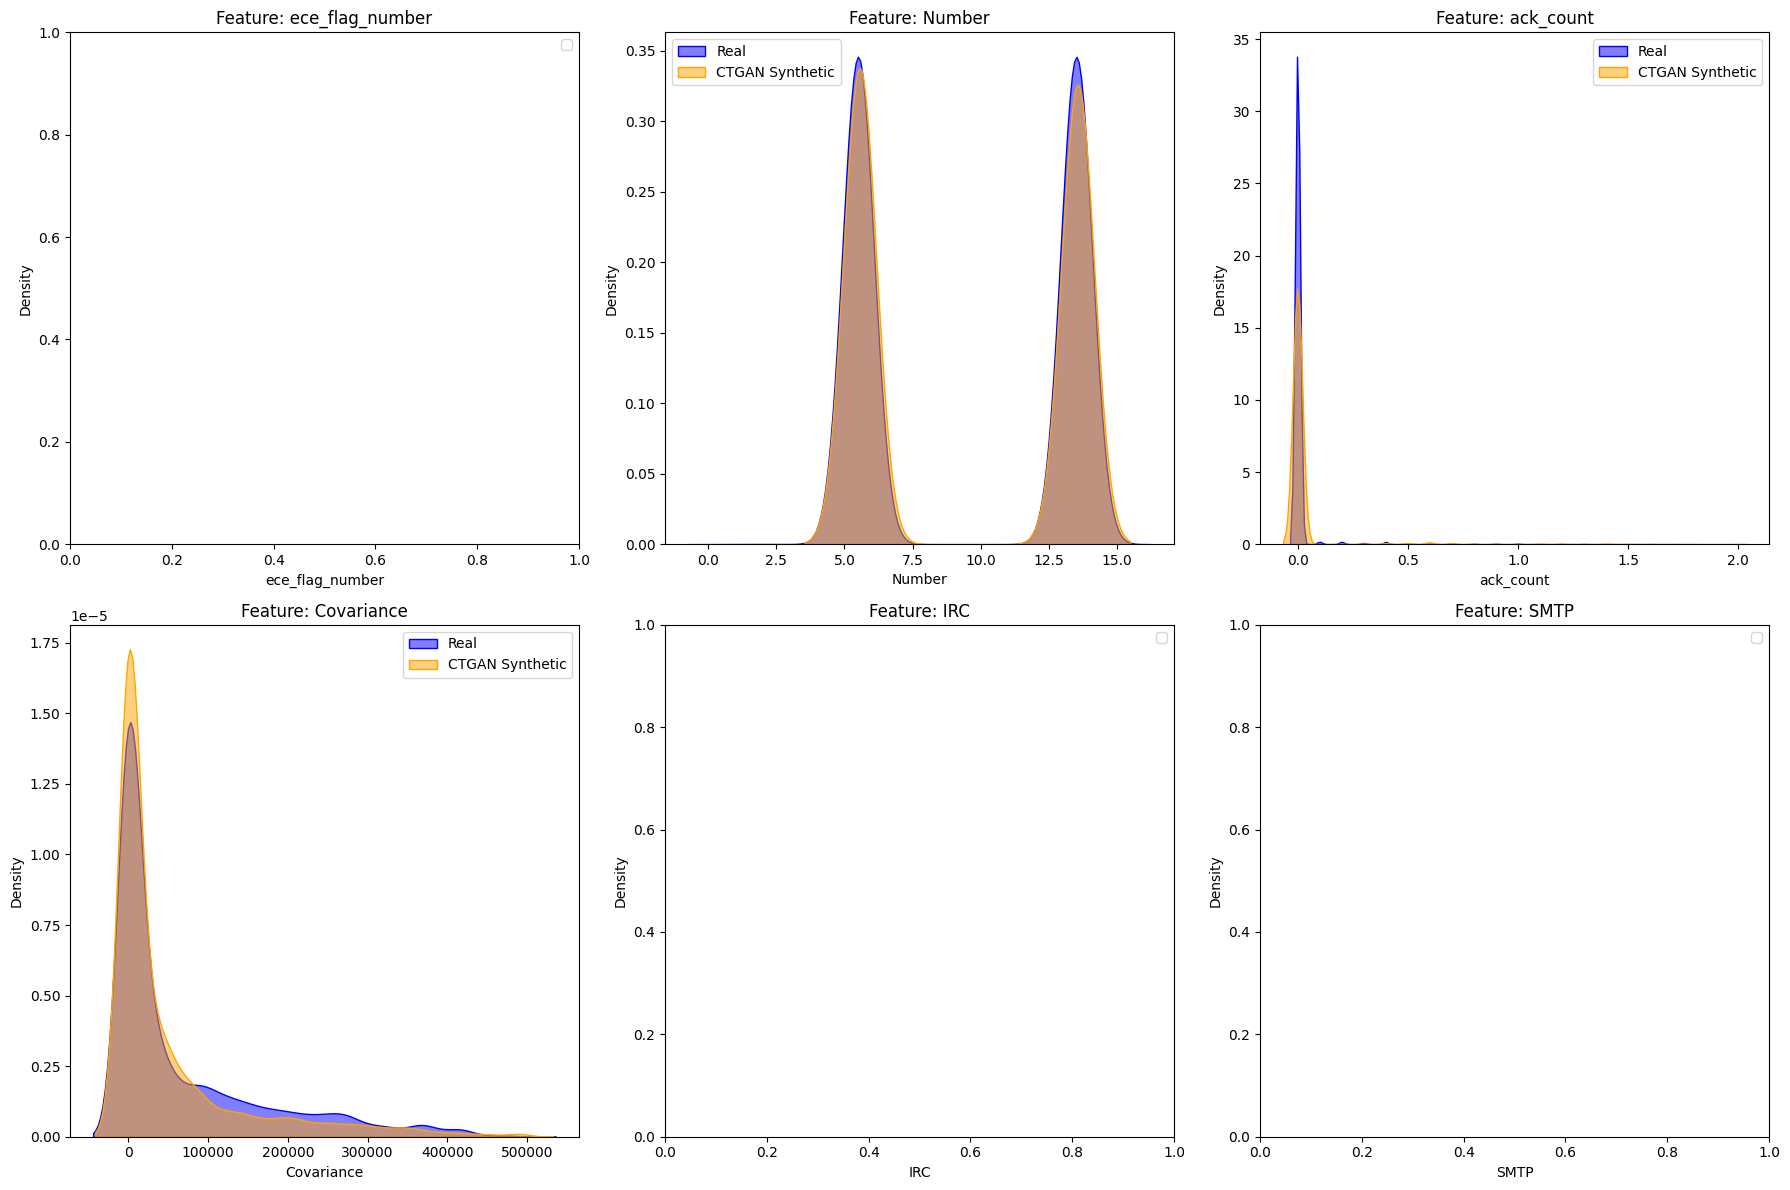

In [48]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Select a few numeric features to visualize
features_to_plot = np.random.choice(num_cols, size=6, replace=False)

plt.figure(figsize=(18, 12))
for i, feature in enumerate(features_to_plot, 1):
    plt.subplot(2, 3, i)
    sns.kdeplot(spoof_df[feature], label="Real", fill=True, alpha=0.5, color="blue")
    sns.kdeplot(synth_data[feature], label="CTGAN Synthetic", fill=True, alpha=0.5, color="orange")
    plt.title(f"Feature: {feature}")
    plt.legend()
plt.tight_layout()
plt.show()

In [49]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report

# Ensure alignment between synth_data and real data
synth_X = synth_data[num_cols]
real_X = spoof_df[num_cols]
synth_y = np.zeros(len(synth_X))  # dummy binary class for classification
real_y = np.ones(len(real_X))

# Combine for domain classifier (optional)
domain_X = pd.concat([synth_X, real_X])
domain_y = np.concatenate([synth_y, real_y])

# --------------------------
# Train Synthetic → Test Real
# --------------------------
X_train_synth = synth_data[num_cols]
y_train_synth = spoof_df['label'].sample(len(X_train_synth), replace=True, random_state=42).values

X_test_real = spoof_df[num_cols]
y_test_real = spoof_df['label'].values

clf = RandomForestClassifier(n_estimators=200, random_state=42)
clf.fit(X_train_synth, y_train_synth)

y_pred_tstr = clf.predict(X_test_real)

print("🎯 TSTR Evaluation Results:")
print(classification_report(y_test_real, y_pred_tstr))
print("✅ TSTR Accuracy:", round(accuracy_score(y_test_real, y_pred_tstr)*100, 2), "%")
print("✅ TSTR F1 Score:", round(f1_score(y_test_real, y_pred_tstr, average='weighted')*100, 2), "%")


🎯 TSTR Evaluation Results:
                    precision    recall  f1-score   support

ARP_Spoofing_train       1.00      1.00      1.00     16047

          accuracy                           1.00     16047
         macro avg       1.00      1.00      1.00     16047
      weighted avg       1.00      1.00      1.00     16047

✅ TSTR Accuracy: 100.0 %
✅ TSTR F1 Score: 100.0 %


In [50]:
domain_clf = RandomForestClassifier(n_estimators=200, random_state=42)
domain_clf.fit(domain_X, domain_y)
domain_pred = domain_clf.predict(domain_X)
domain_acc = accuracy_score(domain_y, domain_pred)
print(f"🔍 Domain Classifier Accuracy: {domain_acc:.3f}")

if domain_acc < 0.65:
    print("Synthetic and Real data are statistically similar (good).")
else:
    print("Domain classifier easily distinguishes synthetic from real (CTGAN needs tuning).")


🔍 Domain Classifier Accuracy: 1.000
Domain classifier easily distinguishes synthetic from real (CTGAN needs tuning).


In [51]:
rf = RandomForestClassifier(n_estimators=300, n_jobs=-1, random_state=42)
rf.fit(X_train, y_train_enc)

y_pred = rf.predict(X_val)
print(classification_report(y_val_enc, y_pred, target_names=le.classes_))

                precision    recall  f1-score   support

        Benign       0.97      0.97      0.97      4800
          DDoS       1.00      1.00      1.00      4800
           DoS       1.00      1.00      1.00      4800
          MQTT       1.00      0.99      1.00      4800
Reconnaissance       0.99      0.97      0.98      4800
      Spoofing       0.96      0.97      0.96      4800

      accuracy                           0.99     28800
     macro avg       0.99      0.99      0.99     28800
  weighted avg       0.99      0.99      0.99     28800



In [52]:
y_pred1 = rf.predict(X_tesubset)
print(classification_report(y_test_enc, y_pred1, target_names=le.classes_))

                precision    recall  f1-score   support

        Benign       0.97      0.97      0.97      6000
          DDoS       1.00      1.00      1.00      6000
           DoS       1.00      1.00      1.00      6000
          MQTT       1.00      0.99      1.00      6000
Reconnaissance       0.99      0.97      0.98      6000
      Spoofing       0.95      0.98      0.96      6000

      accuracy                           0.98     36000
     macro avg       0.98      0.98      0.98     36000
  weighted avg       0.98      0.98      0.98     36000



In [53]:
y_pred

array([5, 5, 3, ..., 0, 2, 1])

In [54]:
X_tesubset

,Header_Length,Protocol Type,Duration,Rate,Srate,Drate,fin_flag_number,syn_flag_number,rst_flag_number,psh_flag_number,...,AVG,Std,Tot size,IAT,Number,Magnitue,Radius,Covariance,Variance,Weight
173417,110.68,6.000,64.0,4.872446,4.872446,0,0.00,0.38,0.62,0.00,...,54.66,0.22250,54.44,8.469641e+07,9.5,10.450,0.3105,0.392390,0.1300,141.500
158607,357.77,6.000,64.0,6.903902,6.903902,0,0.16,0.22,0.02,0.22,...,71.56,7.21500,70.94,8.466704e+07,9.5,11.950,10.2100,76.014626,0.9500,141.500
85865,54.00,6.000,64.0,67.163890,67.163890,0,0.00,0.00,1.00,0.00,...,87.20,106.44000,54.00,1.694103e+08,13.5,13.200,150.9000,11459.288000,1.0000,244.600
130334,5028751.37,7.612,64.1,247.744082,182.026067,0,0.00,0.00,0.00,0.00,...,1242.28,274.83933,195.30,7.469518e+05,5.7,18.184,10.3214,0.000000,0.9119,243.379
115882,112.00,6.000,50.1,7.039019,7.039019,0,0.00,1.00,0.00,0.00,...,58.00,0.00000,58.00,3.409386e-06,5.5,10.770,0.0000,0.000000,0.0000,38.500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90153,225508.20,6.000,229.0,30.892796,30.892796,0,0.00,0.00,0.00,0.30,...,112.25,158.80000,234.60,1.694692e+08,13.5,14.840,225.4000,32103.371000,0.8000,244.600
51244,4683425.47,6.099,64.1,45.966469,0.011909,0,0.00,0.00,0.00,0.00,...,298.48,274.62503,1435.40,0.000000e+00,5.5,21.251,0.0000,3892.425407,0.9134,242.484
123154,419.54,6.110,64.0,6.682323,6.682323,0,0.00,0.62,0.37,0.00,...,55.60,2.71000,55.10,8.467462e+07,9.5,10.540,3.8340,35.871872,0.3700,141.500
19532,5426006.00,17.000,64.0,169.360290,169.360290,0,0.00,0.00,0.00,0.00,...,1252.00,0.00000,1252.00,3.198862e-04,5.5,50.030,0.0000,0.000000,0.0000,38.500


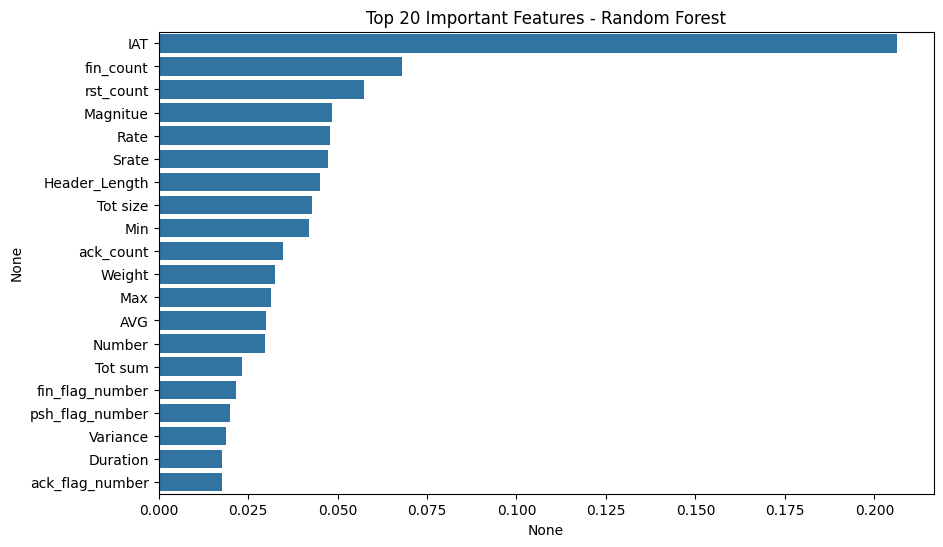

In [55]:
importances = rf.feature_importances_
feat_imp = pd.Series(importances, index=X_train.columns).sort_values(ascending=False)
plt.figure(figsize=(10,6))
sns.barplot(x=feat_imp[:20], y=feat_imp.index[:20])
plt.title("Top 20 Important Features - Random Forest")
plt.show()

In [56]:
import xgboost as xgb
xgb_clf = xgb.XGBClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric='logloss',
    random_state=42,
    n_jobs=4
)

In [57]:
xgb_clf.fit(X_train, y_train_enc)

,objective,'multi:softprob'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'logloss'


In [58]:
y_pred = xgb_clf.predict(X_val)

In [59]:
print(classification_report(y_val_enc, y_pred, target_names=le.classes_))

                precision    recall  f1-score   support

        Benign       0.96      0.98      0.97      4800
          DDoS       1.00      1.00      1.00      4800
           DoS       1.00      1.00      1.00      4800
          MQTT       1.00      1.00      1.00      4800
Reconnaissance       1.00      0.97      0.98      4800
      Spoofing       0.96      0.97      0.97      4800

      accuracy                           0.99     28800
     macro avg       0.99      0.99      0.99     28800
  weighted avg       0.99      0.99      0.99     28800



In [60]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, classification_report
import optuna
import lightgbm as lgb
import catboost as cb
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

In [61]:
def objective_lgb(trial):
    params = {
        "objective": "multiclass",
        "num_class": len(np.unique(y_train)),
        "metric": "multi_logloss",
        "verbosity": -1,
        "boosting_type": "gbdt",
        "learning_rate": trial.suggest_loguniform("learning_rate", 1e-4, 0.1),
        "num_leaves": trial.suggest_int("num_leaves", 20, 120),
        "max_depth": trial.suggest_int("max_depth", 4, 16),
        "feature_fraction": trial.suggest_uniform("feature_fraction", 0.5, 1.0),
        "bagging_fraction": trial.suggest_uniform("bagging_fraction", 0.5, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
        "lambda_l1": trial.suggest_loguniform("lambda_l1", 1e-8, 10.0),
        "lambda_l2": trial.suggest_loguniform("lambda_l2", 1e-8, 10.0)
    }

    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    f1s = []
    for tr_idx, val_idx in skf.split(X_train, y_train):
        X_tr, X_val = X_train.iloc[tr_idx], X_train.iloc[val_idx]
        y_tr, y_val = y_train.iloc[tr_idx], y_train.iloc[val_idx]

        model = lgb.LGBMClassifier(**params)
        model.fit(X_tr, y_tr)
        preds = model.predict(X_val)
        f1s.append(f1_score(y_val, preds, average="macro"))

    return np.mean(f1s)

study_lgb = optuna.create_study(direction="maximize")
study_lgb.optimize(objective_lgb, n_trials=5)
best_lgb = study_lgb.best_params


[I 2025-11-11 03:18:14,926] A new study created in memory with name: no-name-962ecf9a-a346-49cf-8ec1-2f373548fa2f
C:\Users\ABHINAV\AppData\Local\Temp\ipykernel_53068\1541293218.py:8: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

C:\Users\ABHINAV\AppData\Local\Temp\ipykernel_53068\1541293218.py:11: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

C:\Users\ABHINAV\AppData\Local\Temp\ipykernel_53068\1541293218.py:12: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

C:\Users\ABHINAV\AppData\Local\Temp\ipykernel_53068\1541293218.py:14: FutureWarning:

sugges

In [62]:
models = {
    "RandomForest": RandomForestClassifier(n_estimators=300, random_state=42),
    "ExtraTrees": ExtraTreesClassifier(n_estimators=300, random_state=42),
    "AdaBoost": AdaBoostClassifier(n_estimators=300, random_state=42),
    "SVM": SVC(kernel="rbf", C=10, gamma='scale', probability=True),
    "LogisticRegression": LogisticRegression(max_iter=500, multi_class='multinomial')
}

In [63]:
y_val_enc

array([5, 5, 3, ..., 0, 2, 1])

In [64]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, 
    classification_report, confusion_matrix
)

In [65]:
results = {}
detailed_reports = {}
# Best tuned LightGBM
lgb_best = lgb.LGBMClassifier(**best_lgb)
lgb_best.fit(X_train, y_train_enc)
pred_lgb = lgb_best.predict(X_val)
results["LightGBM"] = {
    "Accuracy": accuracy_score(y_val_enc, pred_lgb),
    "Precision_macro": precision_score(y_val_enc, pred_lgb, average="macro"),
    "Recall_macro": recall_score(y_val_enc, pred_lgb, average="macro"),
    "F1_macro": f1_score(y_val_enc, pred_lgb, average="macro")
}
detailed_reports["LightGBM"] = {
    "Classification Report": classification_report(y_val_enc, pred_lgb),
    "Confusion Matrix": confusion_matrix(y_val_enc, pred_lgb)
}

In [66]:
# Others
# for name, model in models.items():
#     model.fit(X_train_scaledd, y_train_enc)
#     preds = model.predict(X_val_scaledd)
#     results[name] = {
#         "Accuracy": accuracy_score(y_val_enc, preds),
#         "Precision_macro": precision_score(y_val_enc, preds, average="macro"),
#         "Recall_macro": recall_score(y_val_enc, preds, average="macro"),
#         "F1_macro": f1_score(y_val_enc, preds, average="macro")
#     }
#     detailed_reports[name] = {
#         "Classification Report": classification_report(y_val_enc, preds),
#         "Confusion Matrix": confusion_matrix(y_val_enc, preds)
# }

In [67]:
# print(results)

In [68]:
# import pyswarms as ps
# from sklearn.model_selection import cross_val_score

# X_vals = X_train_scaledd
# y_vals = y_train.values

# def fitness(x):
#     scores = []
#     for particle in x:
#         mask = particle.astype(bool)
#         if mask.sum() == 0:
#             scores.append(1.0)
#             continue
#         score = -cross_val_score(
#             RandomForestClassifier(n_estimators=150),
#             X_vals[:, mask],
#             y_vals,
#             cv=3,
#             scoring='f1_macro'
#         ).mean()
#         scores.append(score)
#     return np.array(scores)

# optimizer = ps.discrete.BinaryPSO(
#     n_particles=20, dimensions=X_vals.shape[1], options={'c1':1.5,'c2':1.5,'w':0.9}
# )
# cost, pos = optimizer.optimize(fitness, iters=25)
# selected_features = np.where(pos == 1)[0]
# print(f"Selected {len(selected_features)} features out of {X_vals.shape[1]}")

In [70]:
lgbm_best_model = lgb.LGBMClassifier(
    num_leaves=31, learning_rate=0.05, n_estimators=500,
    max_depth=-1, subsample=0.8, colsample_bytree=0.8
)
lgbm_best_model.fit(X_train, y_train_enc)

# CatBoost
catboost_best_model = cb.CatBoostClassifier(
    iterations=500, depth=8, learning_rate=0.05, loss_function='MultiClass',
    verbose=False
)
catboost_best_model.fit(X_train, y_train_enc)

# XGBoost
xgb_best_model = xgb.XGBClassifier(
    max_depth=8, n_estimators=500, learning_rate=0.05,
    subsample=0.8, colsample_bytree=0.8, tree_method="gpu_hist"
)
xgb_best_model.fit(X_train, y_train_enc)

# RandomForest
rf_best_model = RandomForestClassifier(
    n_estimators=300, max_depth=20, min_samples_split=5, n_jobs=-1
)
rf_best_model.fit(X_train, y_train_enc)

d:\Prog\iomt-anomalyze\venv\Lib\site-packages\xgboost\training.py:183: UserWarning:

[03:20:39] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"




,n_estimators,300
,criterion,'gini'
,max_depth,20
,min_samples_split,5
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [71]:
X_train_tensor = torch.tensor(X_train_scaledd, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_enc, dtype=torch.long)
X_test_tensor = torch.tensor(X_test_scaledd, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_enc, dtype=torch.long)

In [75]:
models = {
    "lgbm": lgbm_best_model,
    "catboost": catboost_best_model,
    "xgb": xgb_best_model,
    "rf": rf_best_model
}

In [79]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=5, shuffle=True, random_state=42)
oof_preds = np.zeros((len(X_train), len(np.unique(y_train_enc)), len(models)))

for i, (train_idx, val_idx) in enumerate(kf.split(X_train, y_train_enc)):
    X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_tr, y_val = y_train_enc[train_idx], y_train_enc[val_idx]  # ✅ FIXED

    for j, (name, model) in enumerate(models.items()):
        print(f"\n🔹 Training fold {i+1} - model: {name}")
        model.fit(X_tr, y_tr)
        preds = model.predict_proba(X_val)
        oof_preds[val_idx, :, j] = preds



🔹 Training fold 1 - model: lgbm

🔹 Training fold 1 - model: catboost

🔹 Training fold 1 - model: xgb


d:\Prog\iomt-anomalyze\venv\Lib\site-packages\xgboost\training.py:183: UserWarning:

[03:35:11] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"


d:\Prog\iomt-anomalyze\venv\Lib\site-packages\xgboost\core.py:2676: UserWarning:

[03:35:25] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"


d:\Prog\iomt-anomalyze\venv\Lib\site-packages\xgboost\core.py:729: UserWarning:

[03:35:25] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running 


🔹 Training fold 1 - model: rf

🔹 Training fold 2 - model: lgbm

🔹 Training fold 2 - model: catboost

🔹 Training fold 2 - model: xgb


d:\Prog\iomt-anomalyze\venv\Lib\site-packages\xgboost\training.py:183: UserWarning:

[03:36:07] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"


d:\Prog\iomt-anomalyze\venv\Lib\site-packages\xgboost\core.py:2676: UserWarning:

[03:36:23] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"





🔹 Training fold 2 - model: rf

🔹 Training fold 3 - model: lgbm

🔹 Training fold 3 - model: catboost

🔹 Training fold 3 - model: xgb


d:\Prog\iomt-anomalyze\venv\Lib\site-packages\xgboost\training.py:183: UserWarning:

[03:37:09] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"


d:\Prog\iomt-anomalyze\venv\Lib\site-packages\xgboost\core.py:2676: UserWarning:

[03:37:25] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"





🔹 Training fold 3 - model: rf

🔹 Training fold 4 - model: lgbm

🔹 Training fold 4 - model: catboost

🔹 Training fold 4 - model: xgb


d:\Prog\iomt-anomalyze\venv\Lib\site-packages\xgboost\training.py:183: UserWarning:

[03:38:10] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"


d:\Prog\iomt-anomalyze\venv\Lib\site-packages\xgboost\core.py:2676: UserWarning:

[03:38:25] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"





🔹 Training fold 4 - model: rf

🔹 Training fold 5 - model: lgbm

🔹 Training fold 5 - model: catboost

🔹 Training fold 5 - model: xgb


d:\Prog\iomt-anomalyze\venv\Lib\site-packages\xgboost\training.py:183: UserWarning:

[03:39:09] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"


d:\Prog\iomt-anomalyze\venv\Lib\site-packages\xgboost\core.py:2676: UserWarning:

[03:39:24] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"





🔹 Training fold 5 - model: rf


In [81]:
import pandas as pd
import numpy as np

# Average predictions across models (soft voting)
oof_avg = np.mean(oof_preds, axis=2)  # shape: (n_samples, n_classes)

# Get predicted class (argmax over probabilities)
y_pred_ensemble = np.argmax(oof_avg, axis=1)

# Save to DataFrame for inspection
results_df = pd.DataFrame({
    "True": y_train_enc,
    "Pred": y_pred_ensemble
})

# Optional: compute accuracy, F1 etc.
from sklearn.metrics import accuracy_score, f1_score, classification_report
print("Accuracy:", accuracy_score(y_train_enc, y_pred_ensemble))
print("F1 (macro):", f1_score(y_train_enc, y_pred_ensemble, average="macro"))
print("\nReport:\n", classification_report(y_train_enc, y_pred_ensemble))

# Save predictions to disk
results_df.to_csv("ensemble_oof_results.csv", index=False, decimal=4)
np.save("ensemble_oof_probs.npy", oof_preds)


Accuracy: 0.986015625
F1 (macro): 0.9860555038393288

Report:
               precision    recall  f1-score   support

           0       0.97      0.98      0.97     19200
           1       1.00      1.00      1.00     19200
           2       1.00      1.00      1.00     19200
           3       1.00      0.99      1.00     19200
           4       0.99      0.97      0.98     19200
           5       0.96      0.97      0.97     19200

    accuracy                           0.99    115200
   macro avg       0.99      0.99      0.99    115200
weighted avg       0.99      0.99      0.99    115200



In [85]:
import numpy as np

def create_clients(X, y, num_clients=5):
    """Split dataset into federated client subsets."""
    client_data = []
    data_per_client = len(X) // num_clients
    for i in range(num_clients):
        start = i * data_per_client
        end = (i + 1) * data_per_client if i < num_clients - 1 else len(X)
        client_data.append((X[start:end], y[start:end]))
    return client_data

clients = create_clients(X_train, y_train_enc, num_clients=5)

In [102]:
# import lightgbm as lgb
# import numpy as np
# import copy

# def train_local_lgbm(X_train, y_train, X_val, y_val, rounds=50, params=None):
#     """Train a local LightGBM model for a client."""
#     train_data = lgb.Dataset(X_train, label=y_train)
#     val_data = lgb.Dataset(X_val, label=y_val, reference=train_data)

#     default_params = {
#         'objective': 'multiclass',
#         'num_class': len(np.unique(y_train)),
#         'metric': 'multi_logloss',
#         'verbosity': -1
#     }
#     if params:
#         default_params.update(params)

#     # ✅ Pass only Datasets to valid_sets
#     model = lgb.train(
#         default_params,
#         train_data,
#         num_boost_round=rounds,
#         valid_sets=[val_data],
#         valid_names=["validation"],  # Optional: name for logging
#         callbacks=[
#             lgb.early_stopping(stopping_rounds=10),
#             lgb.log_evaluation(period=0)
#         ]
#     )

#     return model

In [103]:
# global_models = []
# global_rounds = 5

# for r in range(global_rounds):
#     print(f"\n🌐 Global Round {r+1}/{global_rounds}")
#     local_models = []

#     for i, (X_c, y_c) in enumerate(clients):
#         print(f" 🧩 Client {i+1}")
#         local_model = train_local_lgbm(X_c, y_c, X_tesubset, y_test_enc, rounds=50)
#         local_models.append(local_model)

#     global_model = aggregate_models(local_models)
#     global_models.append(global_model)

In [104]:
# def aggregate_models(local_models):
#     """Aggregate LightGBM models by averaging their weights."""
#     global_model = copy.deepcopy(local_models[0])
#     global_boosters = [m for m in local_models]

#     avg_bst = global_boosters[0].dump_model()
#     for i in range(1, len(global_boosters)):
#         bst_i = global_boosters[i].dump_model()
#         for tree_idx in range(len(avg_bst["tree_info"])):
#             avg_bst["tree_info"][tree_idx]["shrinkage"] += bst_i["tree_info"][tree_idx]["shrinkage"]

#     # Average the shrinkage parameter
#     for tree_info in avg_bst["tree_info"]:
#         tree_info["shrinkage"] /= len(global_boosters)

#     global_model.model_from_string(lgb.Booster(model_str=lgb.Booster().model_to_string()).model_to_string())
#     return global_model


In [105]:
# global_models = []
# global_rounds = 5

# for r in range(global_rounds):
#     print(f"\n🌐 Global Round {r+1}/{global_rounds}")
#     local_models = []

#     for i, (X_c, y_c) in enumerate(clients):
#         print(f" 🧩 Client {i+1}")
#         local_model = train_local_lgbm(X_c, y_c, X_tesubset, y_test_enc, rounds=50)
#         local_models.append(local_model)

#     global_model = aggregate_models(local_models)
#     global_models.append(global_model)


In [106]:
# global_model = None
# NUM_ROUNDS = 3

# for rnd in range(NUM_ROUNDS):
#     print(f"\n🌐 Global Round {rnd+1}/{NUM_ROUNDS}")
#     local_models = []

#     for client_id, (X_c, y_c) in enumerate(clients):
#         print(f" 🧩 Client {client_id+1}")
#         local_model = train_local_lgbm(X_c, y_c, X_val, y_val_enc, rounds=50)
#         local_models.append(local_model)

#     global_model = aggregate_models(local_models)

# # Save global model
# global_model.save_model("federated_lgbm.txt")
# print("✅ Federated LightGBM training complete!")


In [107]:
# import shap

# print("\n🧠 Running SHAP XAI on Global Model...")

# explainer = shap.TreeExplainer(global_model)
# shap_values = explainer.shap_values(X_val)

# # Plot summary
# shap.summary_plot(shap_values, X_val, plot_type="bar")

In [117]:
import numpy as np
import lightgbm as lgb
import copy

# Simulate 3 clients — you can adjust this
num_clients = 3
client_data_size = len(X_train) // num_clients

clients = []
for i in range(num_clients):
    X_c = X_train[i * client_data_size:(i + 1) * client_data_size]
    y_c = y_train_enc[i * client_data_size:(i + 1) * client_data_size]

    # Split each client into train-val subset
    X_c_train, X_c_val, y_c_train, y_c_val = train_test_split(
        X_c, y_c, test_size=0.2, random_state=42
    )
    clients.append((X_c_train, y_c_train, X_c_val, y_c_val))

print(f"✅ Created {len(clients)} federated clients")


✅ Created 3 federated clients


In [121]:
def train_local_lgbm(X_train, y_train, X_val, y_val, rounds=50, params=None):
    """Train a local LightGBM model for a federated client."""
    train_data = lgb.Dataset(X_train, label=y_train)
    val_data = lgb.Dataset(X_val, label=y_val, reference=train_data)

    default_params = {
        'objective': 'multiclass',
        'num_class': len(np.unique(y_train)),
        'metric': 'multi_logloss',
        'verbosity': -1
    }
    if params:
        default_params.update(params)

    model = lgb.train(
        default_params,
        train_data,
        num_boost_round=rounds,
        valid_sets=[val_data],
        valid_names=["validation"],
        callbacks=[
            lgb.early_stopping(stopping_rounds=10),
            lgb.log_evaluation(period=10)
        ]
    )

    return model

In [118]:
def safe_recursive_avg(node_g, node_l):
    """Safely average leaf values while handling missing branches."""
    if "leaf_value" in node_g and "leaf_value" in node_l:
        node_g["leaf_value"] = (node_g["leaf_value"] + node_l["leaf_value"]) / 2
    else:
        if "left_child" in node_g and "left_child" in node_l:
            safe_recursive_avg(node_g["left_child"], node_l["left_child"])
        if "right_child" in node_g and "right_child" in node_l:
            safe_recursive_avg(node_g["right_child"], node_l["right_child"])
    return node_g

In [119]:
def aggregate_models(local_models):
    """Federated averaging of LightGBM models (structure-level)."""
    global_model = copy.deepcopy(local_models[0])

    for i in range(1, len(local_models)):
        dump_global = global_model.dump_model()
        dump_local = local_models[i].dump_model()

        # Iterate through each tree
        for t_idx, tree in enumerate(dump_global["tree_info"]):
            global_tree = tree["tree_structure"]
            local_tree = dump_local["tree_info"][t_idx]["tree_structure"]
            safe_recursive_avg(global_tree, local_tree)

    return global_model

In [151]:
from sklearn.metrics import accuracy_score, log_loss

In [154]:
global_models = []
round_metrics = []  # to store (accuracy, loss) per round

for r in range(global_rounds):
    print(f"\n🌐 Global Round {r + 1}/{global_rounds}")
    local_models = []

    for i, (X_c_train, y_c_train, X_c_val, y_c_val) in enumerate(clients):
        print(f" 🧩 Client {i + 1}")
        local_model = train_local_lgbm(X_c_train, y_c_train, X_c_val, y_c_val, rounds=50)
        local_models.append(local_model)

    global_model = aggregate_models(local_models)
    global_models.append(global_model)

    # ---------- ✅ Evaluate Global Model ----------
    y_pred_proba = global_model.predict_proba(X_test)
    y_pred = y_pred_proba.argmax(axis=1)

    acc = accuracy_score(y_test, y_pred)
    loss = log_loss(y_test, y_pred_proba)

    round_metrics.append((acc, loss))
    print(f"🎯 Accuracy: {acc:.4f} | 📉 Log Loss: {loss:.4f}")

print("\n✅ Federated training complete!")
print("📊 Round metrics:", round_metrics)


🌐 Global Round 1/3


TypeError: cannot unpack non-iterable LGBMClient object

In [124]:
# final_model = global_models[-1]
# explainer = shap.TreeExplainer(final_model)
# shap_values = explainer.shap_values(X_val[:200])

# # Global Feature Importance Plot
# shap.summary_plot(shap_values, X_val[:200])

In [127]:
NUM_CLIENTS = 3
GLOBAL_ROUNDS = 5

In [128]:
client_data = np.array_split(X_train, NUM_CLIENTS)
client_labels = np.array_split(y_train, NUM_CLIENTS)

d:\Prog\iomt-anomalyze\venv\Lib\site-packages\numpy\_core\fromnumeric.py:57: FutureWarning:

'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.

d:\Prog\iomt-anomalyze\venv\Lib\site-packages\numpy\_core\fromnumeric.py:57: FutureWarning:

'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.



In [129]:
global_model = lgb.LGBMClassifier(**lgbm_best_model.get_params())

In [130]:
global_models = []


In [133]:
# NUM_CLIENTS = 3
# GLOBAL_ROUNDS = 5

# client_data = np.array_split(X_train, NUM_CLIENTS)
# client_labels = np.array_split(y_train, NUM_CLIENTS)

# global_model = lgb.LGBMClassifier(**lgbm_best_model.get_params())
# global_models = []

# for round_num in range(GLOBAL_ROUNDS):
#     print(f"\n🌐 Global Round {round_num+1}/{GLOBAL_ROUNDS}")
#     local_models = []
    
#     for i in range(NUM_CLIENTS):
#         print(f"  🔹 Client {i+1}")
#         local_model = lgb.LGBMClassifier(**lgbm_best_model.get_params())
#         local_model.fit(client_data[i], client_labels[i])
#         local_models.append(local_model)
    
#     # === Aggregate boosters ===
#     boosters = [m.booster_ for m in local_models]
#     avg_booster = copy.deepcopy(boosters[0])

#     # Average leaf values of each tree (simple aggregation)
#     for i in range(len(boosters)):
#         if i == 0:
#             continue
#         avg_booster.merge(boosters[i])  # merges trees; a simple ensemble-style aggregation

#     # Create a new model with the aggregated booster
#     global_model = lgb.LGBMClassifier(**lgbm_best_model.get_params())
#     global_model._Booster = avg_booster

#     # Evaluate
#     y_pred = global_model.predict(X_val)
#     acc = accuracy_score(y_val, y_pred)
#     print(f"✅ Global Model Accuracy: {acc:.4f}")

#     global_models.append(global_model)

In [134]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
import lightgbm as lgb
from lime.lime_tabular import LimeTabularExplainer
import shap
from tqdm import tqdm
import joblib
import os

In [135]:
def make_clients(X, y, n_clients=4, random_state=42):
    # Split into n_clients using stratified sampling (approx equal size per client)
    idx = np.arange(len(y))
    _, client_idx = train_test_split(idx, test_size=1.0, stratify=y, random_state=random_state)
    # We'll do a repeated stratified split: simpler is random permutation then split by class proportions
    df = pd.DataFrame({'idx': idx, 'y': y})
    clients = []
    for c in range(n_clients):
        # sample indices per class proportional to available
        part = []
        for cls, g in df.groupby('y'):
            gidx = g['idx'].values
            # choose roughly 1/n_clients fraction for each client
            take = int(np.ceil(len(gidx)/n_clients))
            take_idx = gidx[c*take:(c+1)*take]
            if len(take_idx) > 0:
                part.extend(list(take_idx))
        clients.append(np.array(sorted(part, key=int)))
    # Some indices may be missing/overlap; remove empties and ensure disjoint union
    # fallback: simple split by index if above returns empties
    if any(len(c)==0 for c in clients):
        idxs = np.arange(len(y))
        splits = np.array_split(idxs, n_clients)
        clients = [s for s in splits]
    return clients

In [136]:
def train_local_lgbm(X_local, y_local, params=None, num_boost_round=200):
    params = params or {
        "objective":"multiclass", "num_class": len(np.unique(y_local)),
        "verbosity": -1, "metric":"multi_logloss"
    }
    dtrain = lgb.Dataset(X_local, label=y_local)
    bst = lgb.train(params, dtrain, num_boost_round=num_boost_round)
    # wrap into sklearn class for convenient predict_proba
    sk_model = lgb.LGBMClassifier(**{'n_jobs':-1})
    sk_model._Booster = bst
    sk_model.booster_ = bst  # alias
    # monkey patch predict_proba to use booster
    def predict_proba(X):
        ypred = bst.predict(X)
        return ypred
    sk_model.predict_proba = predict_proba
    return sk_model

In [137]:
def client_lime_explain(client_X, client_y, model, feature_names, class_names, n_samples=10, out_dir="client_lime"):
    os.makedirs(out_dir, exist_ok=True)
    explainer = LimeTabularExplainer(
        training_data=np.array(client_X),
        feature_names=feature_names,
        class_names=class_names,
        mode='classification'
    )
    sample_idx = np.random.choice(len(client_X), size=min(n_samples, len(client_X)), replace=False)
    lime_cards = {}
    for i, idx in enumerate(sample_idx):
        x = np.array(client_X.iloc[idx])  # a single row
        exp = explainer.explain_instance(x, model.predict_proba, num_features=min(15, len(feature_names)))
        fname = f"{out_dir}/client_lime_{i}.html"
        exp.save_to_file(fname)
        lime_cards[idx] = fname
    return lime_cards

In [138]:
def compute_client_shap_values(client_model, X_sample, nsamples=200):
    # Use TreeExplainer for LightGBM boosters
    try:
        expl = shap.TreeExplainer(client_model._Booster)
        sv = expl.shap_values(X_sample)  # list: one array per class
        return sv, expl
    except Exception as e:
        print("SHAP TreeExplainer failed:", e)
        return None, None

In [139]:
def average_shap_across_clients(shap_lists):
    # shap_lists: list of shap_values per client; each shap_values is list-of-arrays (class -> (n,features))
    # We'll average per-class and per-feature across clients.
    n_clients = len(shap_lists)
    # ensure same shape
    clients_arr = shap_lists
    n_classes = len(clients_arr[0])
    avg_shap = []
    for k in range(n_classes):
        # for class k: stack arrays shape (n_samples_k, n_features) maybe different n_samples -> average per-feature mean
        # We'll compute the mean absolute shap per feature for each client then average those means
        client_feature_means = []
        for client_shap in clients_arr:
            arr = np.abs(client_shap[k])  # (n_samp, n_feat)
            # reduce to mean over samples -> (n_feat,)
            client_feature_means.append(arr.mean(axis=0))
        client_feature_means = np.stack(client_feature_means, axis=0)  # (n_clients, n_feat)
        avg = client_feature_means.mean(axis=0)  # (n_feat,)
        avg_shap.append(avg)
    return avg_shap

In [140]:
def ensemble_predict_proba(models, X):
    probs = [m.predict_proba(X) for m in models]
    probs = np.stack(probs, axis=0)  # (n_models, n_samples, n_classes)
    avg = probs.mean(axis=0)
    return avg

In [141]:
def federated_simulation(X, y, n_clients=4, params=None, num_boost_round=200, sample_for_shap=500, feature_names=None, class_names=None):
    clients_idx = make_clients(X, y, n_clients=n_clients)
    local_models = []
    client_shap_vals = []

    for i, idxs in enumerate(clients_idx):
        print(f"Training client {i+1}: {len(idxs)} samples")
        Xc = X.iloc[idxs]
        yc = y.iloc[idxs]
        model = train_local_lgbm(Xc.values, yc.values, params=params, num_boost_round=num_boost_round)
        local_models.append(model)

        # client LIME for a few samples (save to disk)
        client_lime_explain(Xc, yc, model, feature_names, class_names, n_samples=6, out_dir=f"client_{i+1}_lime")

        # SHAP on sample (small)
        idxs_shap = np.random.choice(len(Xc), size=min(sample_for_shap, len(Xc)), replace=False)
        Xsh = Xc.iloc[idxs_shap]
        sv, expl = compute_client_shap_values(model, Xsh)
        if sv is not None:
            client_shap_vals.append(sv)
    # Ensemble
    avg_probs = ensemble_predict_proba(local_models, X.values)
    y_pred_ensemble = np.argmax(avg_probs, axis=1)
    # metrics
    print("\nEnsemble metrics:")
    print(classification_report(y, y_pred_ensemble))
    # aggregate SHAP across clients
    avg_shap = average_shap_across_clients(client_shap_vals)
    return local_models, avg_shap, avg_probs

In [142]:
feature_names = X_train.columns.tolist()

In [143]:
feature_names

['Header_Length',
 'Protocol Type',
 'Duration',
 'Rate',
 'Srate',
 'Drate',
 'fin_flag_number',
 'syn_flag_number',
 'rst_flag_number',
 'psh_flag_number',
 'ack_flag_number',
 'ece_flag_number',
 'cwr_flag_number',
 'ack_count',
 'syn_count',
 'fin_count',
 'rst_count',
 'HTTP',
 'HTTPS',
 'DNS',
 'Telnet',
 'SMTP',
 'SSH',
 'IRC',
 'TCP',
 'UDP',
 'DHCP',
 'ARP',
 'ICMP',
 'IGMP',
 'IPv',
 'LLC',
 'Tot sum',
 'Min',
 'Max',
 'AVG',
 'Std',
 'Tot size',
 'IAT',
 'Number',
 'Magnitue',
 'Radius',
 'Covariance',
 'Variance',
 'Weight']

In [144]:
class_names = sorted(y_train.unique().astype(str))

In [145]:
class_names

[np.str_('Benign'),
 np.str_('DDoS'),
 np.str_('DoS'),
 np.str_('MQTT'),
 np.str_('Reconnaissance'),
 np.str_('Spoofing')]

In [146]:
local_models, avg_shap, avg_probs = federated_simulation(
    X=X_train,
    y=y_train_enc,
    n_clients=4,                 # number of clients (adjustable)
    num_boost_round=100,         # local boosting rounds
    feature_names=feature_names, # for LIME
    class_names=class_names,     # for LIME
    sample_for_shap=300          # SHAP sample size per client
)


InvalidParameterError: The 'test_size' parameter of train_test_split must be a float in the range (0.0, 1.0), an int in the range [1, inf) or None. Got 1.0 instead.

In [148]:
# Install Flower if not already installed
import flwr as fl
import lightgbm as lgb
import shap
import numpy as np
from sklearn.metrics import accuracy_score

# Example: Federated Learning setup for LGBM
# Define client class for Flower
class LGBMClient(fl.client.NumPyClient):
    def __init__(self, X_train, y_train, X_test, y_test):
        self.X_train = X_train
        self.y_train = y_train
        self.X_test = X_test
        self.y_test = y_test
        self.model = lgb.LGBMClassifier()

    def get_parameters(self, config):
        return self.model.get_params()

    def fit(self, parameters, config):
        self.model.set_params(**parameters)
        self.model.fit(self.X_train, self.y_train)
        return self.model.get_params(), len(self.X_train), {}

    def evaluate(self, parameters, config):
        self.model.set_params(**parameters)
        preds = self.model.predict(self.X_test)
        acc = accuracy_score(self.y_test, preds)
        return float(acc), len(self.X_test), {}

# Simulate federated clients (split your data)
# X_train, y_train, X_val, y_val should be defined in your notebook
clients = []
num_clients = 3  # Example: 3 clients
X_splits = np.array_split(X_train, num_clients)
y_splits = np.array_split(y_train, num_clients)
for i in range(num_clients):
    clients.append(LGBMClient(X_splits[i], y_splits[i], X_val, y_val))

# Start Flower server and federated training (simulation)
def client_fn(cid):
    return clients[int(cid)]

fl.simulation.start_simulation(
    client_fn=client_fn,
    num_clients=num_clients,
    config=fl.server.ServerConfig(num_rounds=3),
)

# After FL, use SHAP for XAI on the global model
# Assuming global_model is the trained LGBMClassifier
explainer = shap.TreeExplainer(global_model)
shap_values = explainer.shap_values(X_val)
shap.summary_plot(shap_values, X_val, feature_names=X_val.columns)

ImportError: Unable to import module `ray`.

To install the necessary dependencies, install `flwr` with the `simulation` extra:

    pip install -U "flwr[simulation]"
